# Нейроинформатика. Лабораторная работа 5
### Сети с обратными связями

Целью работы является исследование свойств сети Элмана, алогритмов обучения, а также применения сетей в задачах распознавания статических и динамических образов.

Выполнил Лисин Роман, М8О-406Б-20. Вариант 12.

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Layer
from keras import backend as back

import matplotlib.pyplot as plt

Зададим два сигнала - основной сигнал ($p_1$) и сигнал, подлежащий распознаванию ($p_2$)

In [2]:
def fp1(k):
    return np.sin(4 * np.pi * k)

def fp2(k):
    return np.sin(2 * k * k - 6 * k + 3)


k1_begin = 0
k1_end = 1

k2_begin = -0.02
k2_end = 2.36

h = 0.025

r = (2, 5, 6)

Объединим сигналы в один массив - сначала идет r[0] повторений сигнала p1, затем одно повторение сигнала p2, потом r[1] повторений сигнала p1, одно p2 и т.д.

In [3]:
k1 = np.arange(k1_begin, k1_end+h, h)
k2 = np.arange(k2_begin, k2_end+h, h)

p1 = fp1(k1)
p2 = fp2(k2)

p = np.concatenate((
    np.tile(p1, r[0]),
    p2,
    np.tile(p1, r[1]),
    p2,
    np.tile(p1, r[2]),
    p2,
))

t = np.concatenate((
    np.ones(len(p1) * r[0]),
    -np.ones(len(p2)),
    np.ones(len(p1) * r[1]),
    -np.ones(len(p2)),
    np.ones(len(p1) * r[2]),
    -np.ones(len(p2)),
))

x = np.arange(len(p)) * h

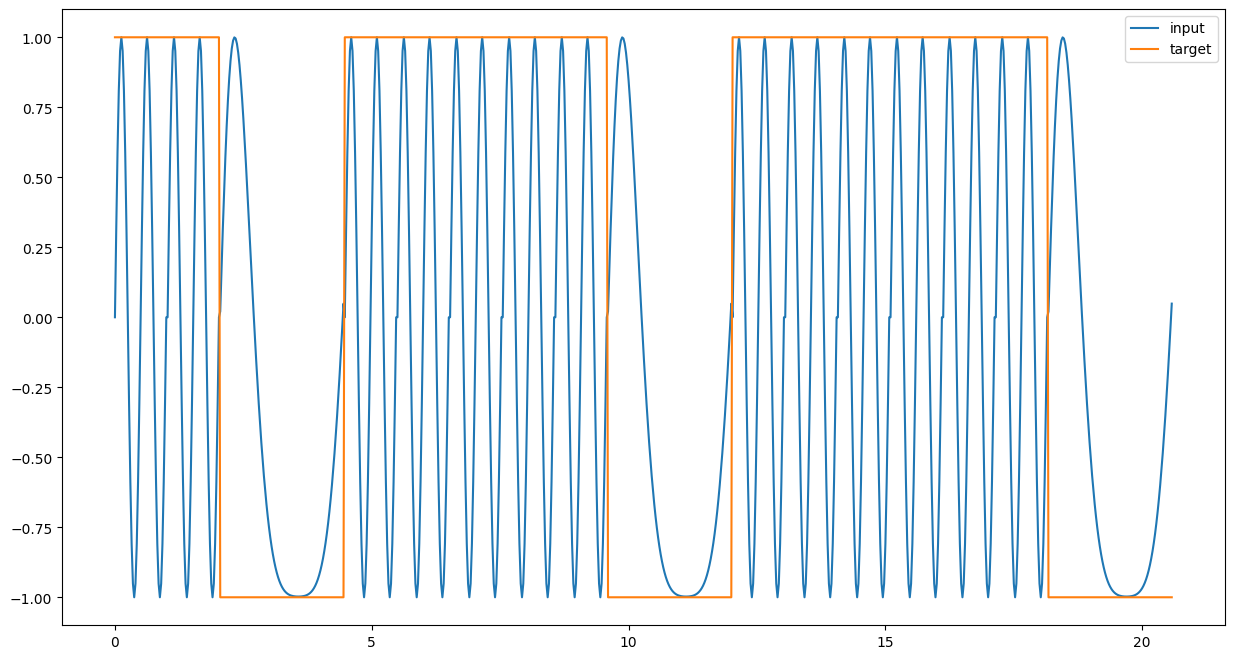

In [4]:
plt.figure(figsize=(15, 8))

plt.plot(x, p, label='input')
plt.plot(x, t, label='target')
plt.legend()

plt.show()

Сгенерируем датасет для обучения. В качестве входных признаков будем брать несколько подряд идущих элементов. Таргеты - тип сигнала в каждой точке промежутка

In [5]:
delay = 5

p_train = np.array([np.hstack([p[i:i+delay]]) for i in range(len(p) - delay)])
t_train = np.array([np.hstack([t[i:i+delay]]) for i in range(len(t) - delay)])

In [6]:
p_train.shape, t_train.shape

((819, 5), (819, 5))

Для обучения будем использовать сеть Элмана. Реализуем слой для нее

In [7]:
class ElmanLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.prev = tf.Variable(tf.zeros((1, output_dim)))
        super(ElmanLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w1 = self.add_weight(
            name='w1',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.w2 = self.add_weight(
            name='w2',
            shape=(self.output_dim, self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.b = self.add_weight(
            name='b',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        super(ElmanLayer, self).build(input_shape)

    def call(self, inputs):
        res = inputs @ self.w1 + self.b
        res += self.prev @ self.w2
        res = tf.keras.activations.tanh(res)
        self.prev.assign(res)
        return res

Подготовим модель. Модель будет состоять из комбинации слоя Элмана и линейного слоя

In [8]:
model = keras.Sequential([
    ElmanLayer(output_dim=8),
    keras.layers.Dense(delay),
])

Обучим ее

In [9]:
model.compile(
    loss='mse',
    optimizer='Adam',
)

In [10]:
train_info = model.fit(
    p_train,
    t_train,
    batch_size=1,
    epochs=150,
)

Epoch 1/150
819/819 [==============================] - 11s 3ms/step - loss: 0.8927
Epoch 2/150
819/819 [==============================] - 3s 4ms/step - loss: 0.8460
Epoch 3/150
819/819 [==============================] - 2s 2ms/step - loss: 0.8488
Epoch 4/150
819/819 [==============================] - 2s 2ms/step - loss: 0.8469
Epoch 5/150
819/819 [==============================] - 2s 2ms/step - loss: 0.8429
Epoch 6/150
819/819 [==============================] - 2s 2ms/step - loss: 0.8405
Epoch 7/150
819/819 [==============================] - 2s 3ms/step - loss: 0.8387
Epoch 8/150
819/819 [==============================] - 3s 3ms/step - loss: 0.8350
Epoch 9/150
819/819 [==============================] - 2s 2ms/step - loss: 0.8339
Epoch 10/150
819/819 [==============================] - 2s 3ms/step - loss: 0.8269
Epoch 11/150
819/819 [==============================] - 2s 2ms/step - loss: 0.8271
Epoch 12/150
819/819 [==============================] - 2s 2ms/step - loss: 0.8237
Epoch 13/150

Посмотрим на лосс

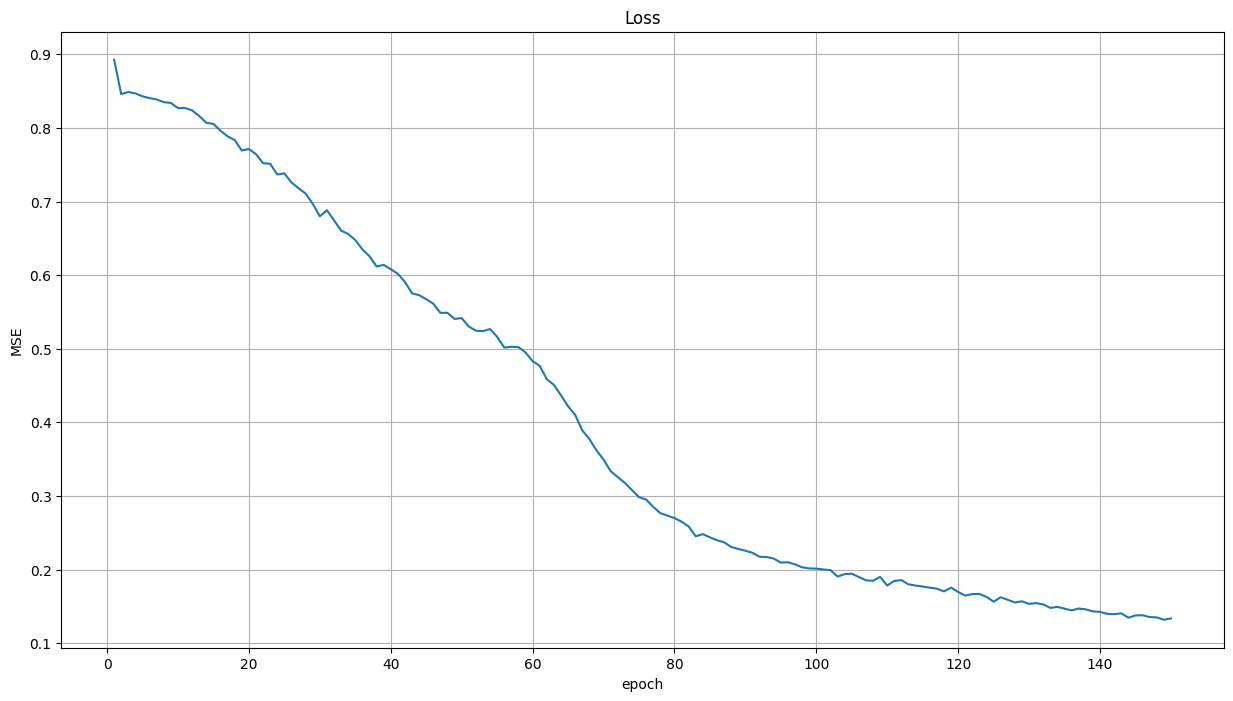

In [11]:
plt.figure(figsize=(15, 8))

loss_history = train_info.history['loss']
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.title('Loss')
plt.grid()

plt.show()

Посмотрим, как справляется обученная сеть с заданием

<ipython-input-12-00848489f1bd>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  preds = np.hstack((


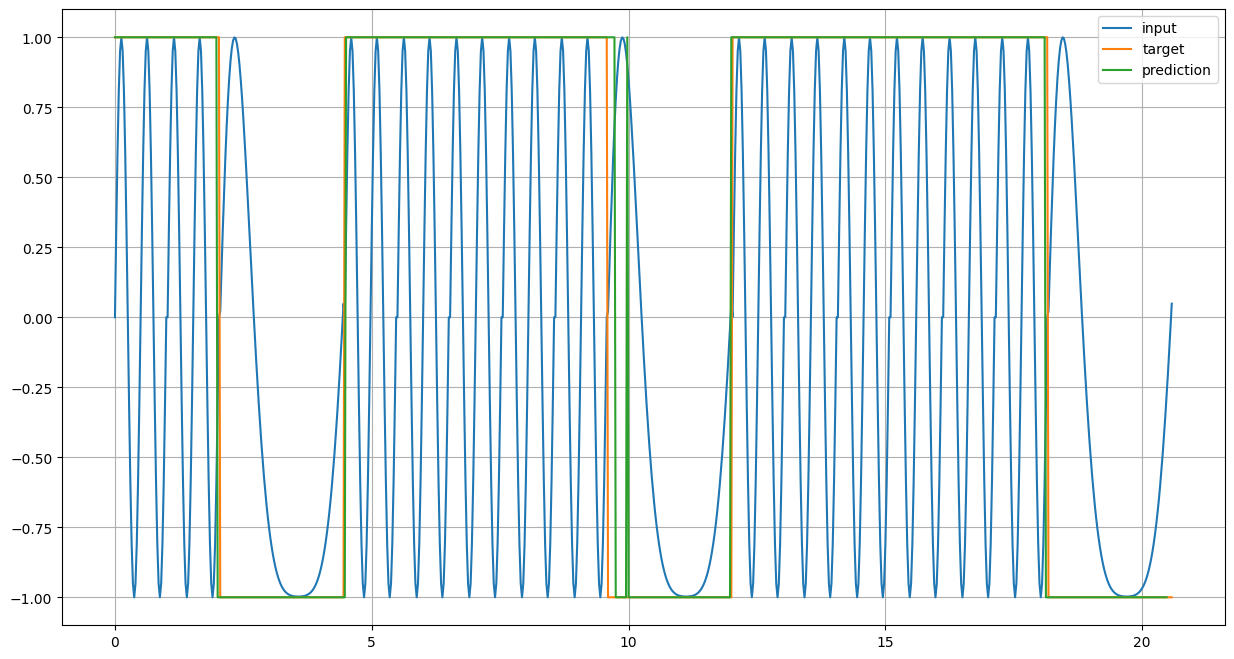

In [12]:
plt.figure(figsize=(15, 8))

preds = np.hstack((
    np.sign(model.predict(
        np.expand_dims(p_train[i], axis=0), verbose=0
    ))
    for i in range(0, len(p_train), delay)
))[0]

plt.plot(x, p, label='input')
plt.plot(x, t, label='target')
plt.plot(x[:-delay+1], preds, label='prediction')

plt.grid()
plt.legend()
plt.show()

Сеть почти всегда правильно угадывает таргет, но с некоторыми погрешностями на границах сигналов

## Вывод

В данной лабораторной работе я познакомился с одним примером сети с обратными связями - сетью Элмана. Я использовал ее для решения задачи определения типа сигнала. Построенная сеть хорошо справляется с задачей